## Parelleization

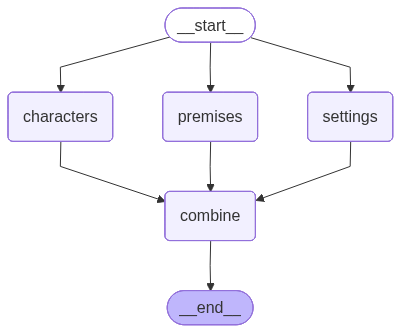

As the last wisps of sunlight faded from the horizon, casting a warm orange glow over the bustling city, Evelyn "Evie" Thompson stood before the ancient clock tower, her eyes fixed on the intricate carvings that adorned its stone façade. The air was alive with the scent of old leather and wood polish, and the soft ticking of the clock's mechanism seemed to reverberate deep within her chest. She felt an inexplicable sense of belonging, as if the very heartbeat of time was calling to her. With a deep breath, Evie pushed open the creaky door and stepped into the tower's musty interior, her footsteps echoing off the walls as she made her way up the narrow, spiral staircase to the clock room.

There, she found Caspian "Cass" Blackwood, his piercing eyes gleaming with a mixture of excitement and trepidation as he gazed upon the magnificent timepiece that dominated the space. The clock's face, a mesmerizing mosaic of brass, silver, and gold, seemed to pulse with an otherworldly energy, and th

In [19]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

# Nodes
def generate_characters(state: State):
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_settings(state: State):
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    msg = llm.invoke(f"Enhance this story premise with vivid details: {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Settings: {state['settings']}\n"
        f"Premises: {state['premises']}"
    )
    return {"story_intro": msg.content}

# Graph
graph = StateGraph(State)
graph.add_node("characters", generate_characters)
graph.add_node("settings", generate_settings)
graph.add_node("premises", generate_premise)
graph.add_node("combine", combine_elements)

# Correct edges
graph.add_edge(START, "characters")
graph.add_edge(START, "settings")
graph.add_edge(START, "premises")
graph.add_edge("characters", "combine")
graph.add_edge("settings", "combine")
graph.add_edge("premises", "combine")
graph.add_edge("combine", END)

compiled_graph = graph.compile()

graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

state = {"topic": "time travel"}
result = compiled_graph.invoke(state)

print(result["story_intro"])


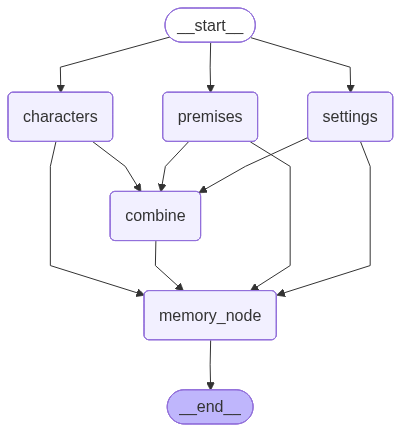


=== STORY INTRO ===

In the heart of a mystical, ancient forest, where the whispers of the past lingered in the rustling of leaves and the soft, ethereal glow of fireflies danced like tiny lanterns, a secret portal waited to unravel the fabric of time. The air was alive with an otherworldly energy, as if the trees themselves were guardians of the timeline, their gnarled branches twisted into cryptic symbols that only the most discerning eye could decipher. It was here that Evelyn "Evie" Thompson, a brilliant and reclusive physicist, and August "Augie" Blackwood, a charismatic historian, had been drawn to the Chronos Spire, an enormous, crumbling clock tower that pierced the sky like a shard of splintered stone.

As they approached the tower, the sound of ticking clockwork echoed through the trees, growing louder with each passing moment, until it became a deafening roar that seemed to reverberate deep within their chests. The forest creatures – the birds, the squirrels, and the deer –

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Load key
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

# ----------------------------------------------------------------
#                     STATE WITH MEMORY
# ----------------------------------------------------------------
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str
    conversation_history: list   # Memory lives here

# ----------------------------------------------------------------
#                     MEMORY NODE
# ----------------------------------------------------------------
def memory_node(state: State):
    """Store outputs from every step into memory."""
    history = state.get("conversation_history", [])

    # Append the current state's snapshot (except memory itself)
    entry = {k: v for k, v in state.items() if k != "conversation_history" and v}
    history.append(entry)

    return {"conversation_history": history}

# ----------------------------------------------------------------
#                     MAIN NODES
# ----------------------------------------------------------------
def generate_characters(state: State):
    msg = llm.invoke(f"Create two character names and traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_settings(state: State):
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    msg = llm.invoke(f"Enhance this story premise with vivid details: {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    msg = llm.invoke(
        f"Write a short story introduction using these:\n\n"
        f"Characters: {state['characters']}\n"
        f"Settings: {state['settings']}\n"
        f"Premises: {state['premises']}\n\n"
        f"Conversation Memory So Far: {state['conversation_history']}"
    )
    return {"story_intro": msg.content}

# ----------------------------------------------------------------
#                     BUILD GRAPH
# ----------------------------------------------------------------
graph = StateGraph(State)

# Add nodes
graph.add_node("characters", generate_characters)
graph.add_node("settings", generate_settings)
graph.add_node("premises", generate_premise)
graph.add_node("combine", combine_elements)
graph.add_node("memory_node", memory_node)

# Normal story workflow
graph.add_edge(START, "characters")
graph.add_edge(START, "settings")
graph.add_edge(START, "premises")

graph.add_edge("characters", "combine")
graph.add_edge("settings", "combine")
graph.add_edge("premises", "combine")

graph.add_edge("combine", END)

# ----------------------------------------------------------------
#            MEMORY HOOK — RUN AFTER EACH NODE
# ----------------------------------------------------------------

# Attach memory node after each step manually
graph.add_edge("characters", "memory_node")
graph.add_edge("settings", "memory_node")
graph.add_edge("premises", "memory_node")
graph.add_edge("combine", "memory_node")

compiled_graph = graph.compile()

# Show diagram
img = compiled_graph.get_graph().draw_mermaid_png()
display(Image(img))

# ----------------------------------------------------------------
#                         RUN
# ----------------------------------------------------------------
state = {
    "topic": "time travel",
    "conversation_history": []  # init memory
}

result = compiled_graph.invoke(state)

print("\n=== STORY INTRO ===\n")
print(result["story_intro"])

print("\n=== MEMORY ===\n")
for i, h in enumerate(result["conversation_history"], 1):
    print(f"{i}. {h}")
